In [3]:
from typing import List
# You need the c lib for graphviz you can get from `conda install graphviz`
# and the python bindings which are `conda install python-graphviz` or similar.
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from vivarium.framework.randomness import choice

#tried `pip install graphviz` instead. will see how far it gets me

In [4]:
def single_person(allowed_states: List[str], 
                  transition_matrix: np.ndarray, 
                  starting_state: str, 
                  model_steps: int = 1000) -> List[str]:    
    encode = lambda state: np.array([1 if s == state else 0 for s in states])  # "One-hot" encoding.
    trajectory = [starting_state]
    for i in range(model_steps):
        x = encode(trajectory[-1])  # get the vector representation of the state
        p = np.matmul(x, transition_matrix)  # Compute transition probabilities
        c = np.random.choice(states, p=p)
        trajectory.append(c)  # Update the new state
        
    return trajectory


def single_trial(allowed_states: List[str],
                 transition_matrix: np.ndarray,
                 starting_state: str,
                 pop_size: int = 10000,
                 model_steps: int = 200,
                 seed: str = 'trial_0'):

    def compute_p(states):    
        return np.array([transition_matrix[allowed_states.index(s)] for s in states])
    
    trajectory = pd.DataFrame(data=[starting_state]*pop_size, columns=[0], index=pd.RangeIndex(pop_size))
    
    for step in range(model_steps):
        p = compute_p(trajectory.loc[:, step])
        trajectory.loc[:, step+1] = choice(seed + str(step), trajectory.index, allowed_states, p)

    outputs = []
    for s in allowed_states:
        s_prop = (trajectory == s).sum()/pop_size
        s_prop = s_prop.to_frame().reset_index().rename(columns={'index': 'step', 0: 'proportion'})
        s_prop['measure'] = s
        outputs.append(s_prop)
    return pd.concat(outputs)

def full_sim(allowed_states: List[str],
             transition_matrix: np.ndarray,
             starting_state: str,
             pop_size: int = 5000,
             model_steps: int = 100,
             n_trials: int = 30):
    trials = []
    for trial in tqdm.trange(n_trials):
        trajectory = single_trial(
            allowed_states,
            transition_matrix,
            starting_state,
            pop_size,
            model_steps,
            seed=f'trial_{trial}'
        )
        trajectory['trial'] = trial
        trials.append(trajectory)
    
    return pd.concat(trials)

## What does the model we're building look like?

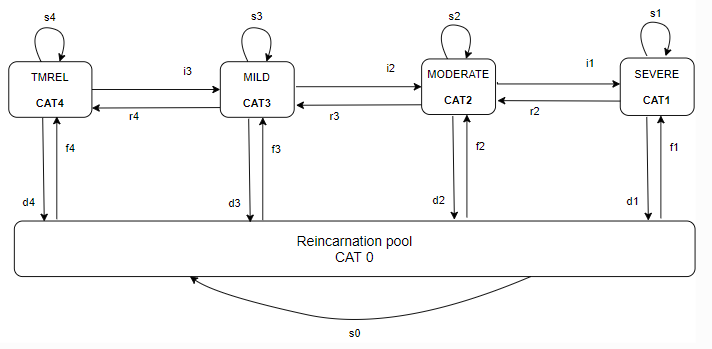

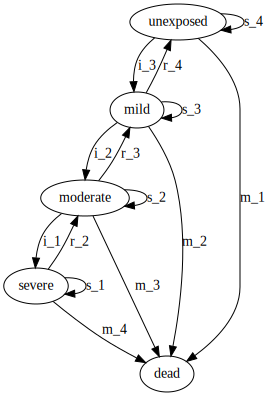

In [5]:
#no death, no birth, no age

SAM = graphviz.Digraph(comment='Child Wasting')

SAM.node('unexposed')
SAM.node('mild')
SAM.node('moderate')
SAM.node('severe')
SAM.node('dead')

#if im in cat 4 unexposed, i can go:
SAM.edge('unexposed', 'mild', label='i_3')
SAM.edge('unexposed', 'unexposed', label='s_4')
SAM.edge('unexposed', 'dead', label='m_1')

#if im in cat 3 mild, i can to:
SAM.edge('mild', 'unexposed', label='r_4')
SAM.edge('mild', 'moderate', label='i_2')
SAM.edge('mild', 'mild', label='s_3')
SAM.edge('mild', 'dead', label='m_2')

#if im in mam/moderate, i can go:
SAM.edge('moderate', 'mild', label='r_3')
SAM.edge('moderate', 'severe', label='i_1')
SAM.edge('moderate', 'moderate', label='s_2')
SAM.edge('moderate', 'dead', label='m_3')

#if i am in severe, i can go:
SAM.edge('severe', 'moderate', label='r_2')
SAM.edge('severe', 'severe', label='s_1')
SAM.edge('severe', 'dead', label='m_4')

SAM.engine = 'dot'
SAM

## Let's make up a parameterization of the model

#  notes

$\pi$ = ($p4$, $p3$, $p2$, $p1$)


|equation|s1|s2|s3|s4|r2|r3|r4|i1|i2|i3|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1|0|0|0|p4|0|0|p3|0|0|0|
|2|0|0|p3|0|0|p2|0|p4|0|0|
|3|0|p2|0|0|p1|0|0|0|p3|0|
|4|p1|0|0|0|0|0|0|p2|0|0|
|5|0|0|0|1|0|0|0|0|0|1|
|6|0|0|1|0|0|0|1|0|1|0|
|7|0|1|0|0|0|1|0|1|0|0|
|8|1|0|0|0|1|0|0|0|0|0|
|9|0|0|0|0|1|0|0|0|0|0|
|10|0|0|0|0|0|1|0|1|0|0|

In [6]:
# states = ['s1','s2','s3','s4','d','']

In [7]:
# #prevalence from GBD 2017

# p4 = 0.7 #prevalence of cat 4 tmrel
# p3 = 0.2 #prevalence of mild
# p2 = 0.07 #prevalence of MAM
# p1 = 0.03 #prevalence of SAM

In [8]:
# a = np.array([[0,0,0,p4,0,0,p3,0,0,0],
# [0,0,p3,0,0,p2,0,p4,0,0],
# [0,p2,0,0,p1,0,0,0,p3,0],
# [p1,0,0,0,0,0,0,p2,0,0],
# [0,0,0,1,0,0,0,0,0,1],
# [0,0,1,0,0,0,1,0,1,0],
# [0,1,0,0,0,1,0,1,0,0],
# [1,0,0,0,1,0,0,0,0,0],
# [0,0,0,0,1,0,0,0,0,0],
# [0,0,0,0,0,1,0,1,0,0]])

In [9]:
# b =np.array([[p4],
# [p3],
# [p2],
# [p1],
# [1],
# [1],
# [1],
# [1],
# [0.0250],
# [0.0143]])

In [10]:
# x = np.linalg.solve(a,b)
# x

In [11]:
# np.allclose(np.dot(a,x),b)

In [12]:
# params = ['s_1', 's_2', 's_3', 's_4', 'r_2', 'r_3', 'r_4', 'i_1', 'i_2', 'i_3']
# # ParamDic = [{i:j} for i, j in zip(params, x.tolist())]

# # ParamDic = {}
# # for key in params:
# #     for value in x.tolist():
# #         ParamDic[key] = value
# # #         test_values.remove(value)b
# #         break  

# # for i,j in params,x:
# #     ParamDic

# # ParamDic = zip(params, x)


# ParamDic = {k:v for (k,v) in zip(params, x.tolist())}
# print((ParamDic))

create a dictionary
key 
d.s_1=x[0]

In [13]:
# s_1 = x[0][0]
# s_2 = x[1][0]
# s_3 = x[2][0]
# s_4 = x[3][0]
# r_2 = x[4][0]
# r_3 = x[5][0]
# r_4 = x[6][0]
# i_1 = x[7][0]
# i_2 = x[8][0]
# i_3 = x[9][0]

# print(i_1)

In [14]:
%cd ..

/ihme/homes/beatrixh/vivarium_research_ciff/wasting_transitions


In [15]:
from set_background_vals import *

/share/code/beatrixh/miniconda/envs/vivarium/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()
/ihme/homes/beatrixh/vivarium_research_ciff/wasting_transitions/set_background_vals.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasting_exp['sex_id'] = np.where(wasting_exp['sex'] == 'Male', 1, 2)
/ihme/homes/beatrixh/vivarium_research_ciff/wasting_transitions/set_background_vals.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [86]:
art = Artifact('/ihme/costeffectiveness/artifacts/vivarium_ciff_sam/ethiopia.hdf', filter_terms=['year_start == 2019', f'age_end <= 5'])
art_wasting_exp = art.load('risk_factor.child_wasting.exposure').reset_index()


/share/code/beatrixh/miniconda/envs/vivarium/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()


In [87]:
wasting_exposures = art_wasting_exp.set_index(['sex', 'age_start', 'age_end', 'year_start', 'year_end']).pivot(columns='parameter')['draw_0'].reset_index()

In [89]:
wasting_exposures = wasting_exposures.loc[
    (wasting_exposures.sex=='Female') &
    (wasting_exposures.age_start==1.0)
]
wasting_exposures

parameter,sex,age_start,age_end,year_start,year_end,cat1,cat2,cat3,cat4
3,Female,1.0,5.0,2019,2020,0.025305,0.095432,0.235557,0.643706


In [90]:
f_1 = float(wasting_exposures.cat1)
f_2 = float(wasting_exposures.cat2)
f_3 = float(wasting_exposures.cat3)
f_4 = float(wasting_exposures.cat4)

3    0.025305
Name: cat1, dtype: float64

In [84]:
f_1, f_2, f_3, f_4 = 0.025305, 0.095432, 0.235557, 0.643706

In [85]:
0.00357142857142857*(7.0*dur_cat3*f_1 - 4.0*dur_cat3*f_2 + 280.0*f_3)/(dur_cat3*f_4)

-0.000132556853406166

In [54]:
dur_cat3 = 365
def set_fs(sex_id, age_group_id):
    # pull prev (for emr)
    f1 = float(wasting_exp.loc[
        (wasting_exp.age_group_id==age_group_id) &
        (wasting_exp.sex_id==sex_id) &
        (wasting_exp.parameter=='cat1')].mean_value)
    f2 = float(wasting_exp.loc[
        (wasting_exp.age_group_id==age_group_id) &
        (wasting_exp.sex_id==sex_id) &
        (wasting_exp.parameter=='cat2')].mean_value)
    f3 = float(wasting_exp.loc[
        (wasting_exp.age_group_id==age_group_id) &
        (wasting_exp.sex_id==sex_id) &
        (wasting_exp.parameter=='cat3')].mean_value)
    f4 = float(wasting_exp.loc[
        (wasting_exp.age_group_id==age_group_id) &
        (wasting_exp.sex_id==sex_id) &
        (wasting_exp.parameter=='cat4')].mean_value)
    
    return f1, f2, f3, f4

for sex in [1,2]:
    for age in [4,5]:
        f1, f2, f3, f4 = set_fs(sex, age)
        print(0.00357142857142857*(7.0*dur_cat3*f_1 - 4.0*dur_cat3*f_2 + 280.0*f_3)/(dur_cat3*f_4))

0.0005425652946279046
0.0005425652946279046
0.0005425652946279046
0.0005425652946279046


In [45]:
def assign_rates():
    s_1 = 0.975
    s_2 = 0.985714285714286
    s_3 = (dur_cat3 - 1.0)/dur_cat3
    s_4 = 0.00357142857142857*(-7.0*dur_cat3*p_1 + 4.0*dur_cat3*p_2 + 280.0*dur_cat3*p_4 - 280.0*p_3)/(dur_cat3*p_4)
    r_2 = 0.025
    r_3 = 0.00357142857142857*(-7.0*p_1 + 4.0*p_2)/p_2
    r_4 = 0.00357142857142857*(7.0*dur_cat3*p_1 - 4.0*dur_cat3*p_2 + 280.0*p_3)/(dur_cat3*p_3)
    i_1 = 0.025*p_1/p_2
    i_2 = 0.00357142857142857*(-7.0*p_1 + 4.0*p_2)/p_3
    i_3 = 0.00357142857142857*(7.0*dur_cat3*p_1 - 4.0*dur_cat3*p_2 + 280.0*p_3)/(dur_cat3*p_4)
    
    return s_1, s_2, s_3, s_4, r_2, r_3, r_4, i_1, i_2, i_3

In [46]:
s_1, s_2, s_3, s_4, r_2, r_3, r_4, i_1, i_2, i_3 = assign_rates()

In [47]:
dur_cat3 = 365

In [ ]:
exposures[data_keys.WASTING.SAM]

In [48]:
# #no deaths for now

# states = ['unexposed', 'mild', 'moderate', 'severe']
# # Transition matrix
# # Rows correspond to the "from" state and column correspond to the "to" state
# T = np.array([
#     [s_4, i_3, 0.0, 0.0], 
#     [r_4, s_3, i_2, 0.0],
#     [0.0, r_3, s_2, i_1],
#     [0.0, 0.0, r_2, s_1],
#     ])
# T




In [49]:
states = ['unexposed','mild','moderate','severe','death']

T = np.array([
    [s_4, i_3, 0.0, 0.0, d_4], 
    [r_4, s_3, i_2, 0.0, d_3],
    [0.0, r_3, s_2, i_1, d_2],
    [0.0, 0.0, r_2, s_1, d_1],
    [f_4, f_3, f_2, f_1, 0.0]
    ])
T

array([[9.99457435e-01, 5.42565295e-04, 0.00000000e+00, 0.00000000e+00,
        2.74960245e-06],
       [1.62391446e-03, 9.97260274e-01, 1.11581156e-03, 0.00000000e+00,
        4.56665516e-06],
       [0.00000000e+00, 2.06051578e-03, 9.85714286e-01, 1.22251985e-02,
        1.03410032e-05],
       [0.00000000e+00, 0.00000000e+00, 2.50000000e-02, 9.75000000e-01,
        3.19073065e-05],
       [6.23631320e-01, 2.08361166e-01, 1.12831846e-01, 5.51756685e-02,
        0.00000000e+00]])

## Run a single person through our sim

In [50]:
states

['unexposed', 'mild', 'moderate', 'severe', 'death']

In [51]:
def single_person(allowed_states: List[str], 
                  transition_matrix: np.ndarray, 
                  starting_state: str, 
                  model_steps: int = 1000) -> List[str]:    
    encode = lambda state: np.array([1 if s == state else 0 for s in states])  # "One-hot" encoding.
    trajectory = [starting_state]
    for i in range(model_steps):
        x = encode(trajectory[-1])  # get the vector representation of the state
        p = np.matmul(x, transition_matrix)  # Compute transition probabilities
        c = np.random.choice(states, p=p)
        trajectory.append(c)  # Update the new state
        
    return trajectory

In [36]:
encode = lambda state: np.array([1 if s == state else 0 for s in states]) 

In [37]:
trajectory = [starting_state]
trajectory

['unexposed']

In [41]:
x = encode(trajectory[-1])
x

array([1, 0, 0, 0, 0])

In [43]:
p = np.matmul(x, transition_matrix)  # Compute transition probabilities
p

array([[-1.20848842e+02,  1.21848842e+02,  0.00000000e+00,
         0.00000000e+00,  2.74960245e-06]])

In [ ]:
c = np.random.choice(states, p=p)

In [33]:
trajectory = single_person(
    allowed_states=states, 
    transition_matrix=T,
    starting_state ='unexposed'
)
    
plt.plot(trajectory)
plt.show()

ValueError: probabilities are not non-negative

## Run for multiple people

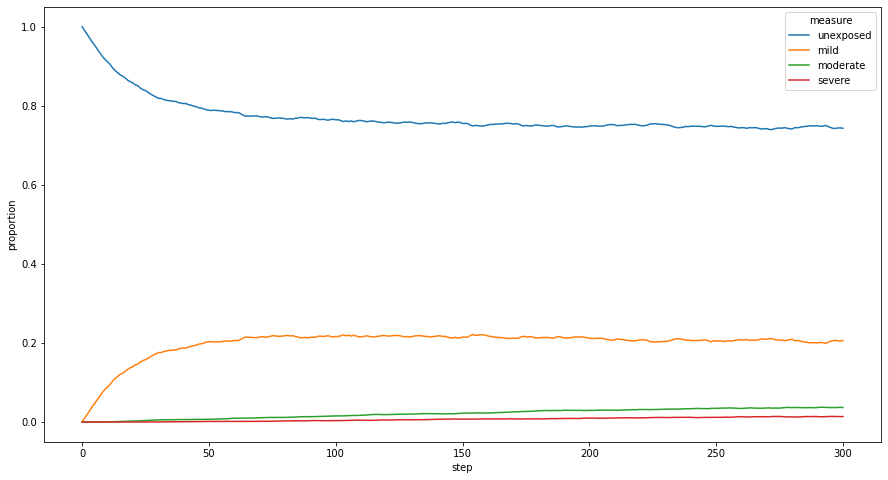

In [41]:
trajectory = single_trial(
    allowed_states=states, 
    transition_matrix=T, 
    starting_state='unexposed',
    pop_size=10000,
    model_steps=300,
)

plt.figure(figsize=(15,8))
sns.lineplot(x='step', y='proportion', hue='measure', data=trajectory)
plt.show()

## Run multiple trials with different random seeds to capture stochastic uncertainty

100%|██████████| 30/30 [00:36<00:00,  1.23s/it]


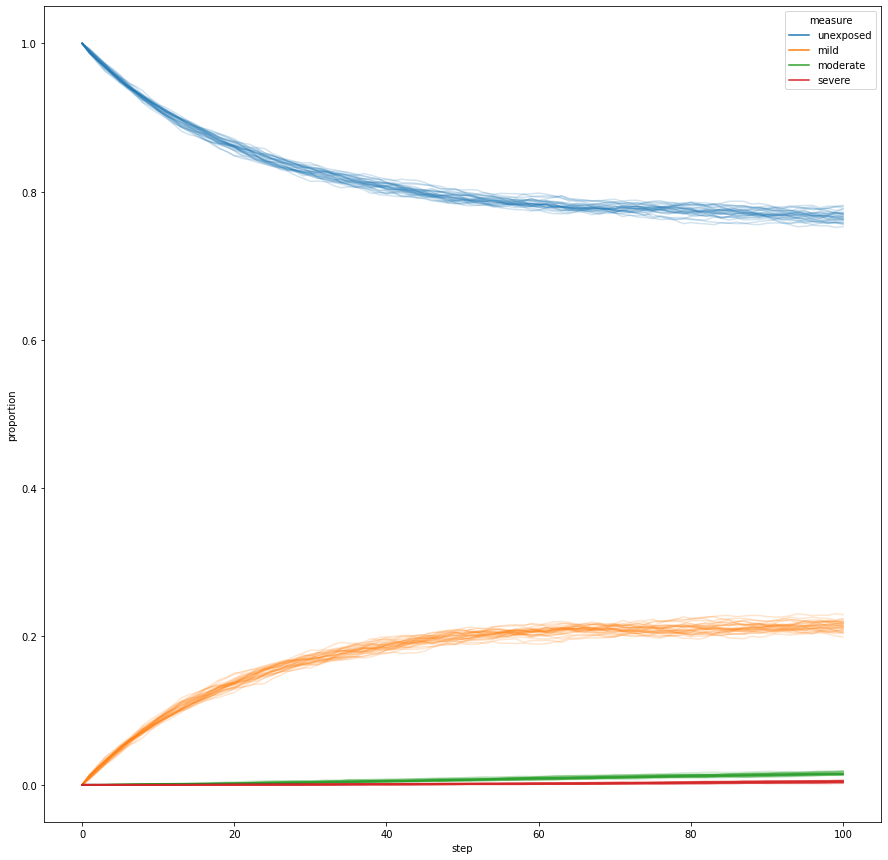

In [42]:
trajectories = full_sim(
    allowed_states=states,
    transition_matrix=T,
    starting_state='unexposed',
    pop_size=5000,
    model_steps=100,
    n_trials=30,
)

plt.figure(figsize=(15,15))
sns.lineplot(x='step', y='proportion', hue='measure', alpha=0.2, estimator=None, units='trial', data=trajectories)
plt.show()